# $\Huge Eksloracja$ $\Huge procesów$


$\Large Julia$  $\Large Witek$













Eksploracja procesów to technika wykorzystywana w analizie procesów, pozwalająca na automatyczne wykrywanie zależności, o działaniu kluczowych dla przedsiębiorstwa procesów. Korzysta ona z narzędzi umożliwiających budowanie, porównywanie oraz ulepszanie modeli, a także ich weryfikacje. Celem eksploracji procesów jest przekształcenie danych o zdarzeniach w schematy, będące punktem wyjścia do analizy wydajności procesów. Dane wykorzystywane w eksploracji procesu, przekazywane są w postaci dzienników zdarzeń, następnie do ich zapisu stosuję się notacje takie jak graf bezpośrednich podążeń, sieć Petriego czy też drzewo procesu. W celu przekształcenia dziennika zdarzeń do postaci grafu można skorzystać z gotowego algorymu. Do przykładowych algorytmów stosowanych w eksploracji procesów należą  Alpha Miner, Inductive Miner oraz Heuristic Miner.


# **Cel pracy**

Celem pracy jest zbadanie możliwości przekształcenia logów wydobytych z dziennika zdarzeń do postaci drzewa procesów, a także określenie przy jakich warunkach jest to możliwe.

# **Drzewo procesów**


Drzewo procesu jest to model oparty na drzewie, w którym wewnętrzne wierzchołki reprezentują relacje(przepływy), a liście reprezentują czynności procesu. Jest to hierarchiczna reprezentacja procesu odpowiadająca matematycznemu pojęciu drzewa zakorzenionego, tj. nieskierowanego grafu acyklicznego.

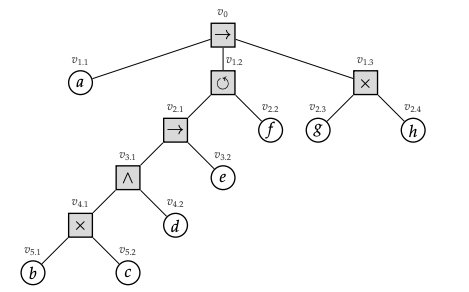

**Rysunek 1.** Przykład drzewa procesów, przedstawiającego wszystkie podstawowe konstrukcje przepływów. [1]



* Etykieta → określa, że wszystkie podległe czynności wykonywane są od lewej do prawej strony tzn. w pierwszej kolejności zostanie wykonana czynność *a*, następnie czynności odpowiadające gałęzi środkowej, natomiast na końcu wykonywane są czynności z gałęzi prawej. 

* Etykietaimage.png określa zachowanie cykliczne tzn. czynność z lewej strony jest wykonywana zawsze, natomiast czynność z prawej strony wymaga powtórzenia czynności ze strony lewej.

* Etykieta × określa bramkę XOR tzn. może być wykonana zarówno czynność *g* jak i *h*, jednak nigdy nie obie.

* Etykieta ∧ odnosi się do współbierzności tzn. czynności posiadające ten sam wierzchołek mogą być wykonywane w tym samym czasie.




Drzewo procesów, w odróżnieniu od innych notacji, z definicji jest modelem poprawnym. Poprawność modelu jest to parametr zakładający, że model jest w stanie dotrzeć ze stanu początkowego do stanu końcowego bez napotkania niejednoznaczności. Model procesu w formie drzewa pozwala też uzyskać równoważną specyfikację logiczną, a także pozwala w łatwy sposób zrozumieć zachowanie procesu. Ponadto rekurencyjna definicja drzew procesów sprawia, że są one wygodną reprezentacją do iteracyjnego rozszerzania modeli procesów.

# **Przygotowanie środowiska**

## **Instalacja bibliotek**

In [ ]:
!pip install pm4py

In [ ]:
!apt install libgraphviz-dev

In [ ]:
!pip install pygraphviz

## **Importy**

In [4]:
import os
import pandas as pd
import pm4py
from functools import reduce
from itertools import groupby
from itertools import chain
from more_itertools import pairwise
from collections import Counter
import pygraphviz as pgv
from IPython.display import Image, display
from datetime import datetime

from pm4py.objects.log.importer.xes import importer as xes_importer

# miners
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner


# converters
from pm4py.objects.conversion.wf_net import converter as wf_net_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter


# vizualizations
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.petri_net import visualizer as petri_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer


# **Dziennik zdarzeń**


Dane wejściowe do odkrycia procesu przechowywane są w dzienniku zdarzeń. 

In [6]:
# EXAMPLE FROM PM4Py
log_pm4py = pm4py.format_dataframe(pd.read_csv("running-example.csv", sep=','), 
                                   case_id='case:concept:name', activity_key='Activity',timestamp_key='time:timestamp')
# EXAMPLE FROM AGH
log_agh = pm4py.format_dataframe(pd.read_csv("repairExample.csv", sep=','), 
                                   case_id='Case ID', activity_key='Activity',timestamp_key='Start Timestamp')
# EXAMPLE FROM AGH2
log_agh2 = pm4py.format_dataframe(pd.read_csv("purchasingexample.csv", sep=','),
                                  case_id='Case ID', activity_key='Activity',timestamp_key='Start Timestamp')

log_pm4py_test = log_pm4py.copy()
log_agh_test = log_agh.copy()
log_agh2_test = log_agh2.copy()

W dzienniku zdarzeń możemy zwykle znaleźć wiele atrybutów, jednak większość algorytmów wykorzystywanych w eksploracji procesów potrzebuje trzech: identyfikatora przypadku, śladu czasu oraz nazwy samej czynności.


Poniżej przedstawiono trzy dzienniki zdarzeń dotyczące różnych procesów biznesowych:

In [7]:
log_pm4py.head()

,Activity,Costs,Resource,case:concept:name,case:creator,org:resource,time:timestamp,concept:name,@@index
0,register request,50,Pete,1,Fluxicon Nitro,Pete,2010-12-30 10:02:00+00:00,register request,0
1,examine thoroughly,400,Sue,1,Fluxicon Nitro,Sue,2010-12-31 09:06:00+00:00,examine thoroughly,1
2,check ticket,100,Mike,1,Fluxicon Nitro,Mike,2011-01-05 14:12:00+00:00,check ticket,2
3,decide,200,Sara,1,Fluxicon Nitro,Sara,2011-01-06 10:18:00+00:00,decide,3
4,reject request,200,Pete,1,Fluxicon Nitro,Pete,2011-01-07 13:24:00+00:00,reject request,4


In [8]:
log_pm4py.shape

(42, 9)

In [9]:
log_agh.head()

,Case ID,Activity,Resource,Start Timestamp,Complete Timestamp,Variant,Variant index,(case) creator,(case) variant,(case) variant-index,defectFixed,defectType,lifecycle:transition,numberRepairs,org:resource,phoneType,case:concept:name,concept:name,time:timestamp,@@index
0,1,Register,System,1970-01-02 12:23:00+00:00,1970-01-02 12:23:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,NaN,NaN,complete,NaN,System,NaN,1,Register,1970-01-02 12:23:00+00:00,0
1,1,Analyze Defect,Tester3,1970-01-02 12:23:00+00:00,1970-01-02 12:30:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,NaN,6,complete,NaN,Tester3,T2,1,Analyze Defect,1970-01-02 12:23:00+00:00,1
2,1,Repair (Complex),SolverC1,1970-01-02 12:31:00+00:00,1970-01-02 12:49:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,NaN,NaN,complete,NaN,SolverC1,NaN,1,Repair (Complex),1970-01-02 12:31:00+00:00,2
3,1,Test Repair,Tester3,1970-01-02 12:49:00+00:00,1970-01-02 12:55:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,true,NaN,complete,0,Tester3,NaN,1,Test Repair,1970-01-02 12:49:00+00:00,3
4,1,Inform User,System,1970-01-02 13:10:00+00:00,1970-01-02 13:10:00+00:00,Variant 2,2,Fluxicon Disco,Variant 2,2,NaN,NaN,complete,NaN,System,NaN,1,Inform User,1970-01-02 13:10:00+00:00,4


In [10]:
log_agh.shape

(8838, 20)

In [11]:
log_agh2.head()

,Case ID,Start Timestamp,Complete Timestamp,Activity,Resource,Role,case:concept:name,concept:name,time:timestamp,@@index
0,1,2011-01-01 00:00:00+00:00,2011-01-01 00:37:00+00:00,Create Purchase Requisition,Kim Passa,Requester,1,Create Purchase Requisition,2011-01-01 00:00:00+00:00,0
1,1,2011-01-01 05:37:00+00:00,2011-01-01 05:45:00+00:00,Create Request for Quotation,Kim Passa,Requester,1,Create Request for Quotation,2011-01-01 05:37:00+00:00,1
2,1,2011-01-01 06:41:00+00:00,2011-01-01 06:55:00+00:00,Analyze Request for Quotation,Karel de Groot,Purchasing Agent,1,Analyze Request for Quotation,2011-01-01 06:41:00+00:00,2
3,1,2011-01-01 11:43:00+00:00,2011-01-01 12:09:00+00:00,Send Request for Quotation to Supplier,Karel de Groot,Purchasing Agent,1,Send Request for Quotation to Supplier,2011-01-01 11:43:00+00:00,3
4,1,2011-01-01 12:32:00+00:00,2011-01-01 16:03:00+00:00,Create Quotation comparison Map,Magdalena Predutta,Purchasing Agent,1,Create Quotation comparison Map,2011-01-01 12:32:00+00:00,4


In [12]:
log_agh2.shape

(9119, 10)

Zdarzenia występujące w dzienniku możemy pogrupować w obrębie jednego przypadku, a następnie na podstawie czasu początkowego stworzyć grupy będące tzw. śladami, które można zliczyć. Taka operacja pozwoli nam na identyfikacje wszystkich możliwych śladów.

In [13]:
# log_pm4py

#Routes discover
log_pm4py_test = (log_pm4py
    .sort_values(by=['case:concept:name','time:timestamp'])
    .groupby(['case:concept:name'])
    .agg({'Activity': ';'.join})
)

#Routes counter
log_pm4py_test['count'] = 0

log_pm4py_test = (log_pm4py_test.groupby('Activity', as_index = False).count().sort_values(['count'], ascending = False).reset_index(drop=True))
log_pm4py_test.head()

,Activity,count
0,register request;check ticket;examine casually...,1
1,register request;check ticket;examine thorough...,1
2,register request;examine casually;check ticket...,1
3,register request;examine casually;check ticket...,1
4,register request;examine casually;check ticket...,1


W powyższym przykładzie możemy zauważyć 6 różnych śladów, każdy z nich rozpoczyna się od czynności *register request*, natomiast kończy się na czynności *pay compensation* bądź *reject request*. W podanym dzienniku zdarzeń każdy ze śladów wystąpił zaledwie jednokrotnie.

In [14]:
# log_agh

#Routes discover
log_agh_test['Start Timestamp'] = pd.to_datetime(log_agh_test['Start Timestamp'])


log_agh_test = (log_agh_test
    .sort_values(by=['Case ID','Start Timestamp'])
    .groupby(['Case ID'])
    .agg({'Activity': ';'.join})
)

#Routes counter
log_agh_test['count'] = 0

log_agh_test = (log_agh_test.groupby('Activity', as_index = False).count().sort_values(['count'], ascending = False).reset_index(drop=True))
log_agh_test.head()

,Activity,count
0,Register;Analyze Defect;Repair (Complex);Infor...,253
1,Register;Analyze Defect;Repair (Complex);Test ...,193
2,Register;Analyze Defect;Repair (Simple);Test R...,108
3,Register;Analyze Defect;Inform User;Repair (Co...,78
4,Register;Analyze Defect;Repair (Simple);Inform...,75


W powyższym przykładzie możemy wyróżnić 60 śladów, występujących z częstotliwościa od 1 do nawet 253 razy. Każdy ze śladów rozpoczyna się od czynności *register*, natomiast kończy się na czynności *end*.

In [15]:
# log2_agh

#Routes discover
log_agh2_test['Start Timestamp'] = pd.to_datetime(log_agh2_test['Start Timestamp'])


log_agh2_test = (log_agh2_test
    .sort_values(by=['Case ID','Start Timestamp'])
    .groupby(['Case ID'])
    .agg({'Activity': ';'.join})
)

#Routes counter
log_agh2_test['count'] = 0

log_agh2_test = (log_agh2_test.groupby('Activity', as_index = False).count().sort_values(['count'], ascending = False).reset_index(drop=True))
log_agh2_test.head()

,Activity,count
0,Create Purchase Requisition;Analyze Purchase R...,88
1,Create Purchase Requisition;Create Request for...,77
2,Create Purchase Requisition;Analyze Purchase R...,63
3,Create Purchase Requisition;Analyze Purchase R...,48
4,Create Purchase Requisition;Create Request for...,32


Ostatni z przykładów zawiera 70 śladów, najczęstszy ślad wystąpił w dzienniku zdarzeń 88 razy. Każdy ślad rozpoczyna się od zdarzenia *Create Purchase Requisition* natomiast kończy się na *Analyze Request for Quotation* bądź *Pay Invoice*.

Aby dokładniej prześledzić co dzieje się w dzienniku zdarzeń, możemy przedstawić go za pomocą grafu bezpośrednich podążeń. 

## **Graf bezpośrednich podążeń**

W grafie bezpośrednich podążeń wierzchołki odpowiadają zadaniom, a
krawędzie odpowiadają relacji bezpośredniego podążania. Bezpośrednie podążanie oznacza wystąpienie jednego zdarzenia bezpośrednio po drugim w danym śladzie.
Model ten daje pogląd na zachodzący proces, jednak w wielu przypadkach może być mylący. 

In [16]:
def draw_graph(log):
  
  log['trace'] = [trace.split(';') for trace in  log['Activity']]

  w_net = dict()
  ev_start_set = set()
  ev_end_set = set()
  for index, row in log[['trace','count']].iterrows():
    if row['trace'][0] not in ev_start_set:
      ev_start_set.add(row['trace'][0])
    if row['trace'][-1] not in ev_end_set:
      ev_end_set.add(row['trace'][-1])
    for ev_i, ev_j in pairwise(row['trace']):
      if ev_i not in w_net.keys():
        w_net[ev_i] = Counter()
      w_net[ev_i][ev_j] += row['count']

  G = pgv.AGraph(strict=False, directed=True)
  G.graph_attr['rankdir'] = 'LR'
  G.node_attr['shape'] = 'Mrecord'
  for event, succesors in w_net.items():
    G.add_node(event, style="rounded,filled", fillcolor="#ffffcc")
    G.add_edges_from([(event, sc) for sc in succesors])
  G.draw('simple_heuristic_net.png', prog='dot')
  display(Image('simple_heuristic_net.png'))

Z pierwszego zestawu logów udało się otrzymać następujący graf:

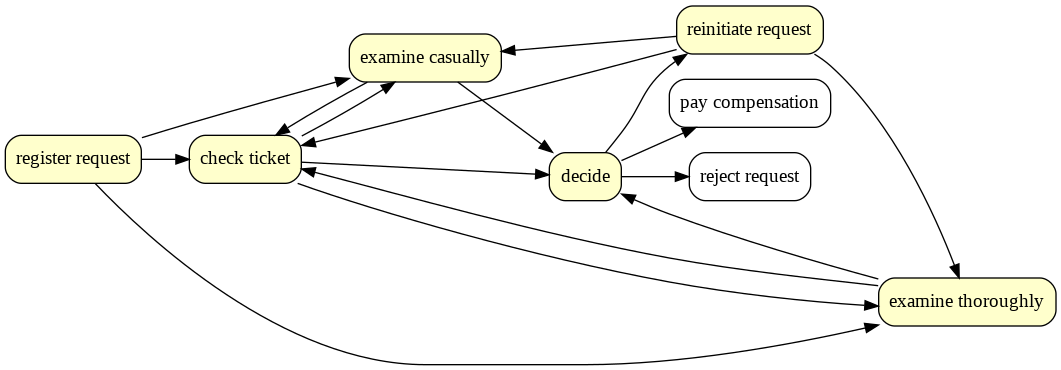

In [17]:
draw_graph(log_pm4py_test)

Widzimy, że zdarzenia końcowe tj. *pay compensation* oraz *reject request*, w przeciwieństwie do innych zdarzeń, zostały oznaczone kolorem białym.

Z drugiego zestawu logów otrzymano graf postaci:

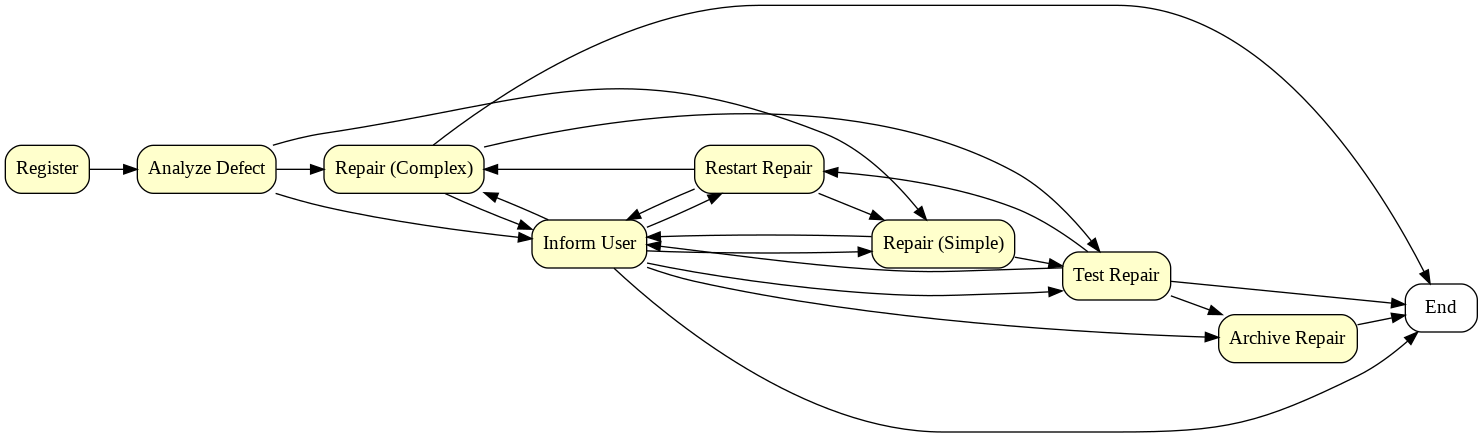

In [18]:
draw_graph(log_agh_test)

Trzeci zestawu logów pozwolił na otrzymanie grafu:

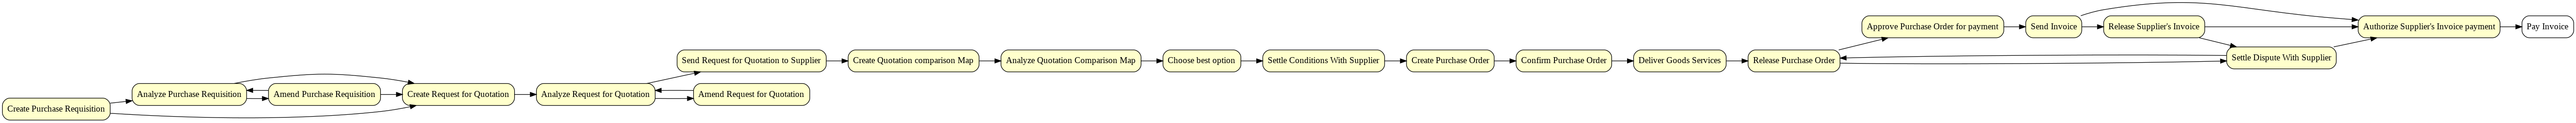

In [19]:
draw_graph(log_agh2_test)

Graf ten różni się on nieco od poprzednich, jest znacznie dłuższy, a także charakteryzuje się stosunkowo niewielką ilością przepływów. Możemy zauważyć, że jedno ze zdarzeń końcowych dla niektórych ścieżek, a mianowicie *Analize Request for Quantation*,  jest jednocześnie "środkowym" zdarzeniem dla innych ścieżek. 

Aby dokładniej zobrazować proces, możemy pokolorować zadania według ich wystąpień w dzienniku zdarzeń, a także dodać odpowiednie etykiety w zależności od tego,
jak często w logu występowało dane zdarzenie albo przepływ.

In [20]:
def draw_graph(dfs, case_id, timestamp, activity):
  ev_counter = dfs.Activity.value_counts()
  dfs = (dfs
      .sort_values(by=[case_id, timestamp])
      .groupby([case_id])
      .agg({activity: ';'.join})
  )
  dfs['count'] = 0
  dfs = (
      dfs.groupby(activity, as_index=False).count()
      .sort_values(['count'], ascending=False)
      .reset_index(drop=True)
  )
  dfs['trace'] = [trace.split(';') for trace in dfs[activity]]

  w_net = dict()
  ev_start_set = set()
  ev_end_set = set()
  for index, row in dfs[['trace','count']].iterrows():
      if row['trace'][0] not in ev_start_set:
          ev_start_set.add(row['trace'][0])
      if row['trace'][-1] not in ev_end_set:
          ev_end_set.add(row['trace'][-1])
      for ev_i, ev_j in pairwise(row['trace']):
          if ev_i not in w_net.keys():
              w_net[ev_i] = Counter()
          w_net[ev_i][ev_j] += row['count']

  trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
  trace_min = trace_counts[0]
  trace_max = trace_counts[-1]
  color_min = ev_counter.min()
  color_max = ev_counter.max()
  
  G = pgv.AGraph(strict= False, directed=True)
  G.graph_attr['rankdir'] = 'LR'
  G.node_attr['shape'] = 'Mrecord'

  G.add_node("start", shape="circle", label="")
  for ev_start in ev_start_set:
    G.add_edge("start", ev_start)

  for event, succesors in w_net.items():
    value = ev_counter[event]
    color = int(float(color_min-value)/float(color_min-color_max)*100.00)
    label = str(event) + ": " + str(ev_counter[event])
    my_color = "#ff9933"+str(hex(color))[2:]
    G.add_node(event, style="rounded,filled", fillcolor=my_color, label=label)
    for succesor, cnt in succesors.items():
      G.add_edge(event, succesor, penwidth=4*cnt/(trace_max-trace_min)+0.1, label=cnt)

  G.add_node("end", shape="circle", label="", penwidth='3')
  for ev_end in ev_end_set:
    G.add_edge(ev_end, "end")

  G.draw('simple_heuristic_net_with_events.png', prog='dot')
  display(Image('simple_heuristic_net_with_events.png'))

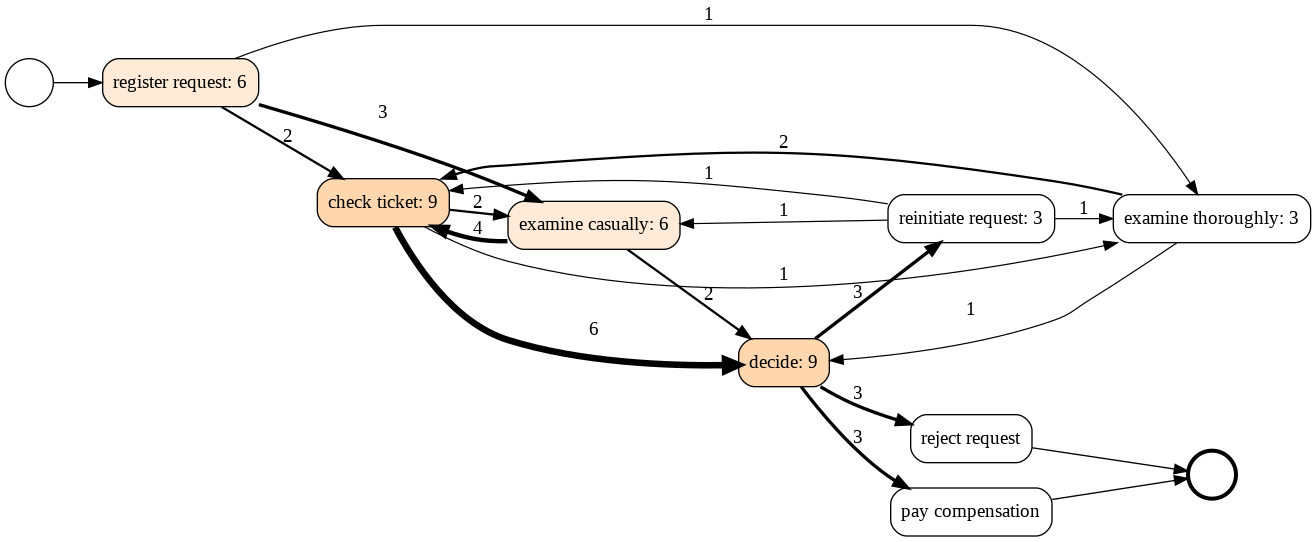

In [21]:
draw_graph(log_pm4py, 'case:concept:name', 'time:timestamp', 'Activity')

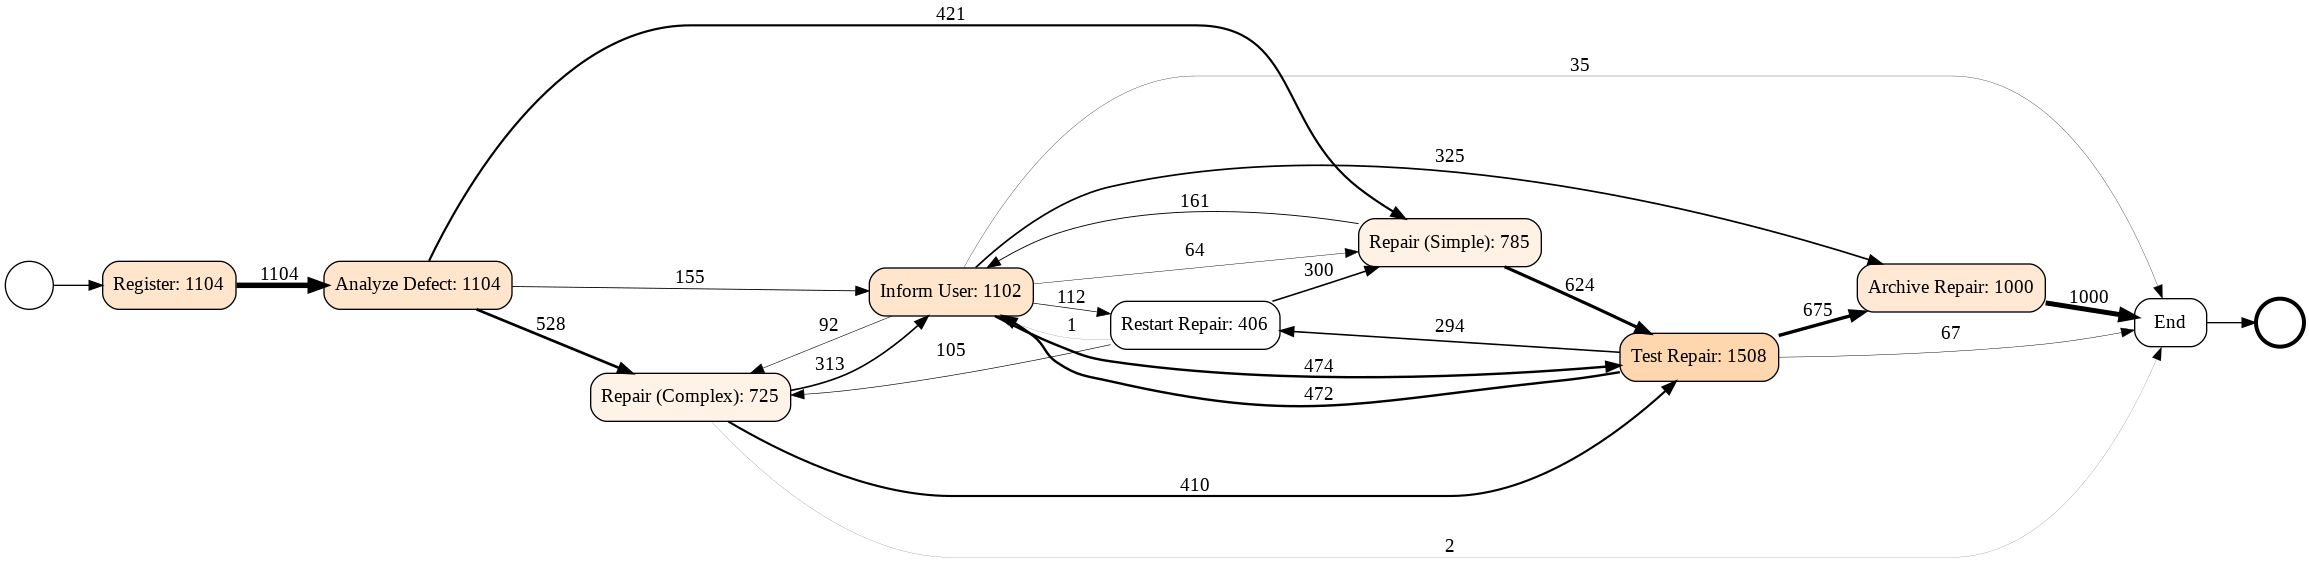

In [22]:
draw_graph(log_agh, 'Case ID', 'Start Timestamp', 'Activity')

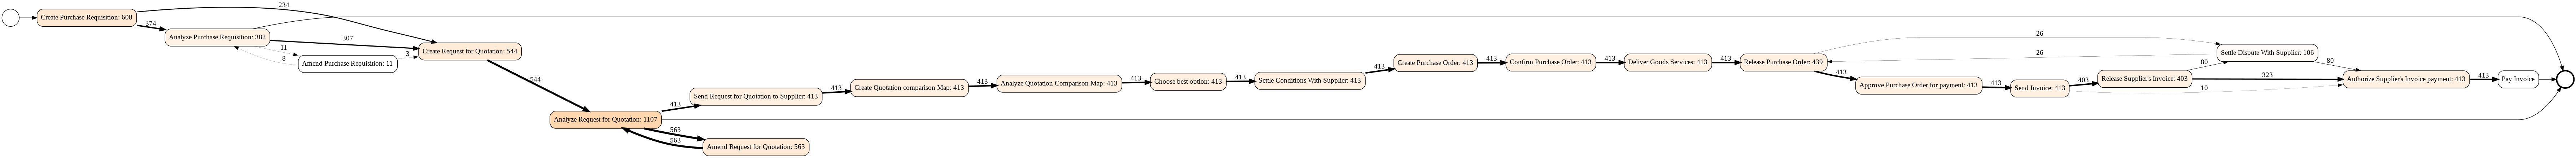

In [23]:
draw_graph(log_agh2, 'Case ID', 'Start Timestamp', 'Activity')

# **Sieć Petriego**

Sieć Petriego składa się z miejsc, przejści oraz znaczników. Każde przejście może być uruchomione tylko jeżeli w miejscach wchodzących znajdują się znaczniki i w miejscach wychodzących znajdują się miejsca na znaczniki. Jeśli w miejscu wchodzącym nie mielibyśmy znaczników to uruchomienie przejścia jest niemożliwe.
Miejsca i przejścia są ze sobą połączone za pomocą krawędzi tak, aby nigdy dwa przejścia nie były połączone ze sobą bezpośrednio (czyli pomiędzy dwoma przejściami zawsze jest przynajmniej jedno
miejsce). Czasem w sieci pojawiają się też ciche przejścia (ang. silent transitions), oznaczone czarnym prostokątem, które mają właściwości przejścia, jednak nie są powiązane
z żadną aktywnością. 

Istnieje algorytm, który tłumaczy sieć WF-net na drzewo procesów. Algorytm wykrywa, czy sieć WF-net odpowiada drzewu procesów, a jeśli tak, konstruuje je.
 
WF-net to specyficzyny rodzaj sieci Petriego zawierajacy zarówno miejsce początkowe jak i miejsce końcowe.
 

## **Konwersja sieci Petriego na drzewo procesów**

Posiadając model sieci WF po dokonaniu redukcji jesteśmy w stanie przedstawić proces w formie drzewa wtedy, kiedy zredukowana sieć zawiera tylko jedną tranzycje. Podana sieć posiada wtedy stukturę blokową. Ponadto sieć, którą chemy przekonwertować musi być poprawna. Oznacza to, że jest możliwe dotarcie ze stanu początkowego do stanu końcowego bez napotkania błędów. Podana sieć nie może zawierać martwych przejść, a więc wszystkie przejścia muszą posiadać możliwość aktywacji. Sieć musi posiadać możliwość ukończenia oraz prawidłowe zakończenie. Oznacza to, że z każdego miejsca, do którego da się dotrzeć z miejsca początkowego, musi się również dać dotrzeć do miejsca końcowego oraz gdy w miejscu początkowym znajduję się żeton, w żadnym innym miejscu nie może się już znajdować żeton.



Przejście z sieci Wf-net na drzewo polega na stopniowej redukcji sieci na coraz mniejsze zachowania dające się wyrazić w notacji drzewa. Gdy odnajdziemy część, która może zostać zredukowana, zamieniamy ją na mniejszy fragment reprezentujący drzewo procesu. Jeżeli przetwarzana w ten sposób sieć sprowadza się na końcu do pojedynczego przejścia, przejście z Wf-net na drzewo procesu jest możliwe. 



 
 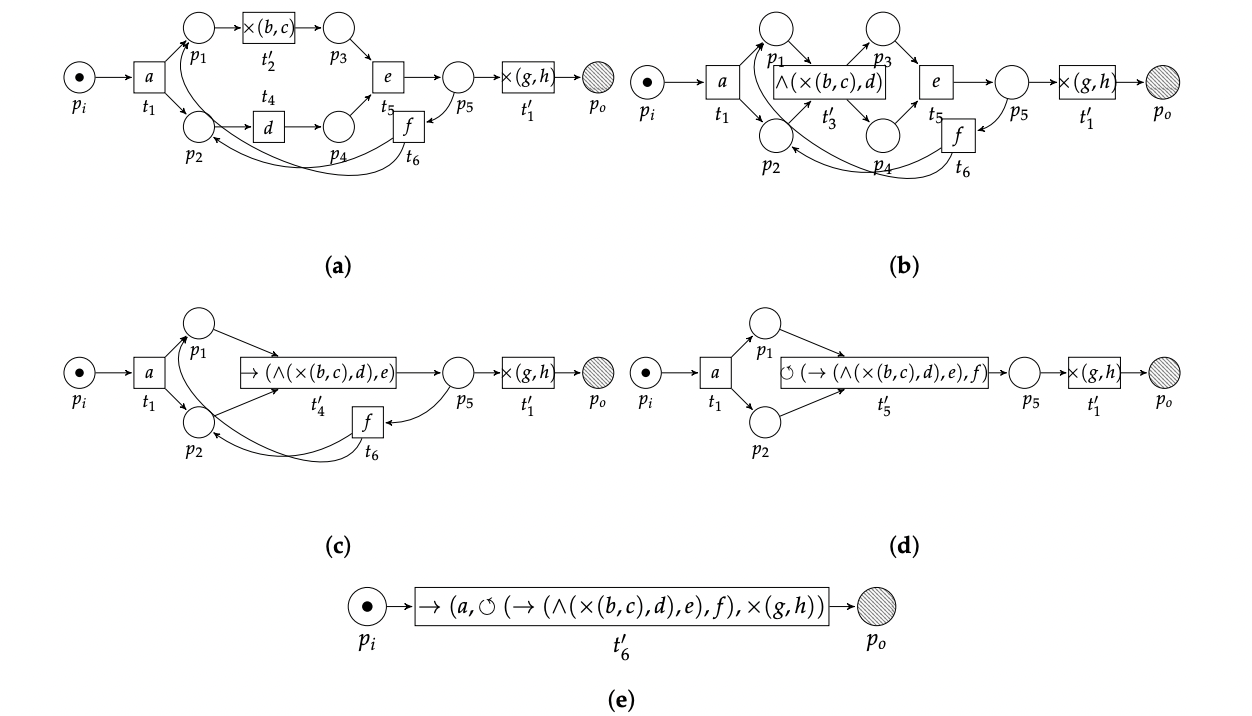
**Rysunek 2.** Przykład zasady działania algorytmu tłumaczącego WF-net na drzewo procesów [1].

1. 	Algorytm wybiera dwie struktury przykładowo jedna pomiędzy tranzycją b i c a jedna między tranzycją g i h.
2. 	Algorytm zastępuje fragmenty za pomocą dwóch nowych przejść oznaczanych jako x(b,c), x(g,h)
3. 	Następnie dobierana jest następna para np. x(b,c) i d itd.
4. 	Rezultatem jest drzewo procesu i odpowiada ono podpunktowi (e)

Powyższy algorytm został zaproponowany w pracy  "Translating Workflow Nets to Process Trees: An Algorithmic Approach." autorstwa Sebastiaana van Zelta oraz Sandera J. J. Leemansa.

# **Implementacja z wykorzystanie biblioteki PM4PY**

Biblioteka PM4PY proponuje implementację algorytmu konwertującego sieć Petriego o strukturze blokowej w drzewo procesów. W tym celu konieczne jest, aby podana sieć Petriego była siecią WF, w przeciwnym wypadku algorytm zwraca odpowiedni komunikat. W przypadku gdy konwersja do postaci drzewa nie jest możliwa algorytm zwraca komunikat "Parsing of WF-net Failed".

## Przygotowanie danych



In [24]:
#DATA PREPERATION

#pm4py
slog_pm4py = log_pm4py[['case:concept:name', 'Activity', 'time:timestamp']]

#agh
slog_agh = log_agh[['Case ID', 'Activity', 'Start Timestamp']]

#agh2
slog_agh2 = log_agh2[['Case ID', 'Activity', 'Start Timestamp']]


In [25]:
log = log_pm4py.copy()
log1 = log_agh.copy()
log2 = log_agh2.copy()

## **Przykład I**

### **Alpha Miner**



Alpha Miner jest jednym z najbardziej znanych algorytmów eksploracji procesów i jest w stanie znaleźć:

* Model sieci Petriego, w którym wszystkie przejścia są widoczne i niepowtarzalne oraz odpowiadają sklasyfikowanym zdarzeniom.
* Miejsce początkowe opisujące stan modelu sieci Petriego w momencie rozpoczęcia wykonywania.
* Miejsce końcowe opisujące stan modelu sieci Petriego po zakończeniu wykonania.




In [26]:
net_a, initial_marking_a, final_marking_a = alpha_miner.apply(log)
tree_a = wf_net_converter.apply(net_a, initial_marking_a, final_marking_a)

Zwizualizujmy więc sieć Petriego na podstawie algorytmu Alpha Miner.

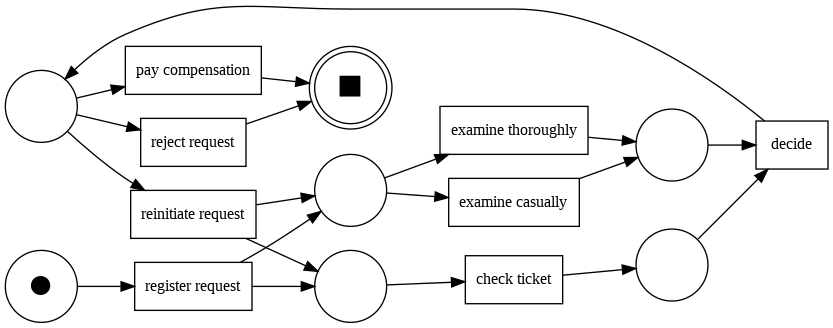

In [27]:
gviz = pm4py.visualization.petri_net.visualizer.apply(net_a, initial_marking_a, final_marking_a)
petri_visualizer.view(gviz)

Skoro udało się otrzymać powyższą sieć jest ona siecią WF. Analizując jej przebieg widzimy, że nie posiada ona martwych przejść, ma możliwość ukończenia oraz prawidłowe zakończenie. Jeśli posiada również strukturę blokową to możliwe jest jej przekształcenie do postaci drzewa.

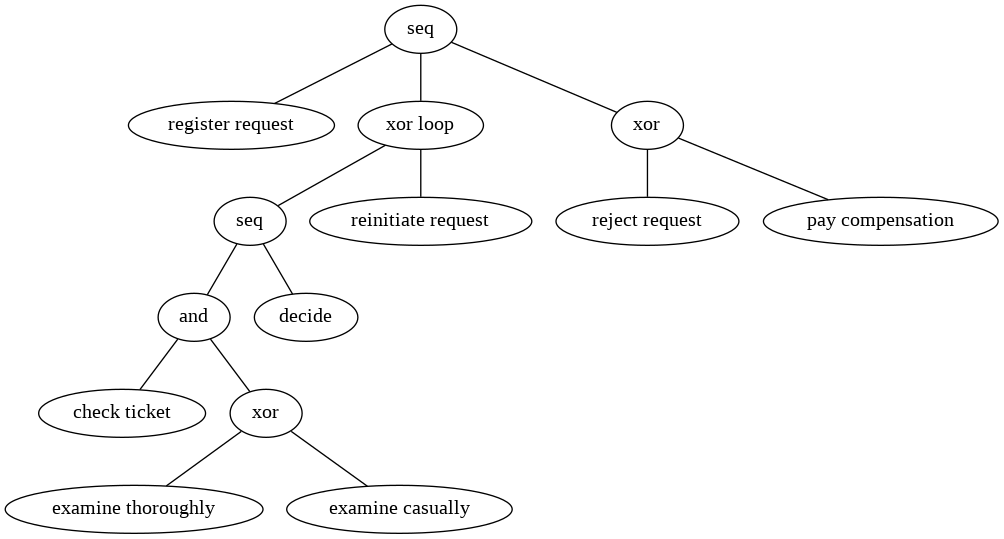

In [28]:
gviz = pt_visualizer.apply(tree_a, 
                           parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
pt_visualizer.view(gviz)


Podany dziennik zdarzeń da więc się sprowadzić do postaci drzewa z wykorzystaniem algorytmu Alpha Miner.

### **Inductive Miner**

Algorytmy z tej grupy zwracają model w postaci drzewa procesu. Konwersja drzewa
procesu w sieć procesu jest łatwo osiągalna, a uzyskana sieć jest zawsze poprawna. W ramach działania algorytmu tworzony jest graf bezpośrednich podążeń, w ramach którego dokonywany jest podział logów. W wyniku podziału powstają pod-logi, które następnie poddaje się dalszym podziałom, do momentu
pozostania jedynie jednej aktywności. Operacja podziału logów oparta jest
o wzorce omówione w zakładce *Drzewo procesów*: sekwencyjny (→), wyłącznego wyboru (×), równoległości (∧) oraz pętli (⟳). Gdy
wzorzec zostanie rozpoznany, jego symbol umieszczany jest jako wierzchołek drzewa, a powstałe
pod-logi umieszczane są na galęziach.

Biblioteka PM4PY umożliwia otrzymanie dwóch modeli procesów: sieci Petriego oraz drzewa.
Aby uzyskać sieć Petriego odczytywany jest dziennik zdarzeń, nakładany jest algorytm Inductive Miner oraz odnajdywana jest sieć Petriego wraz z początkowym i końcowym oznaczeniem.

In [29]:
net_i, initial_marking_i, final_marking_i = inductive_miner.apply(log)
tree_i = inductive_miner.apply_tree(log)

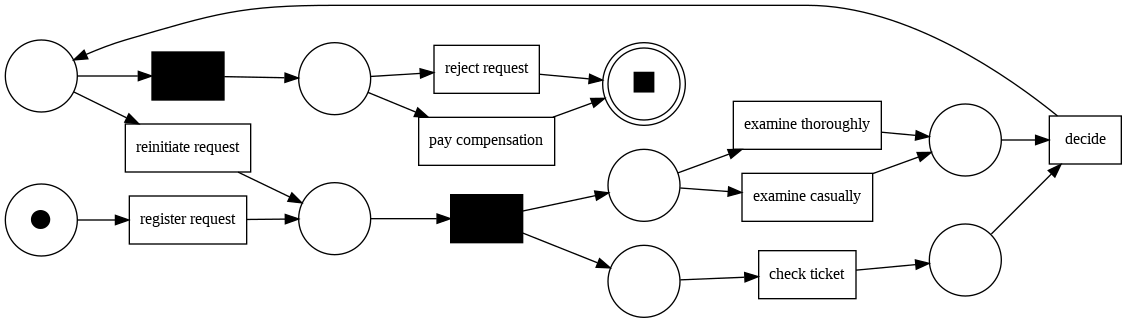

In [30]:
gviz = pm4py.visualization.petri_net.visualizer.apply(net_i, initial_marking_i, final_marking_i)
petri_visualizer.view(gviz)

Wizualizacja dziennika zdarzeń w postaci drzewa procesu za pomocą algorytmu Inductive Miner.

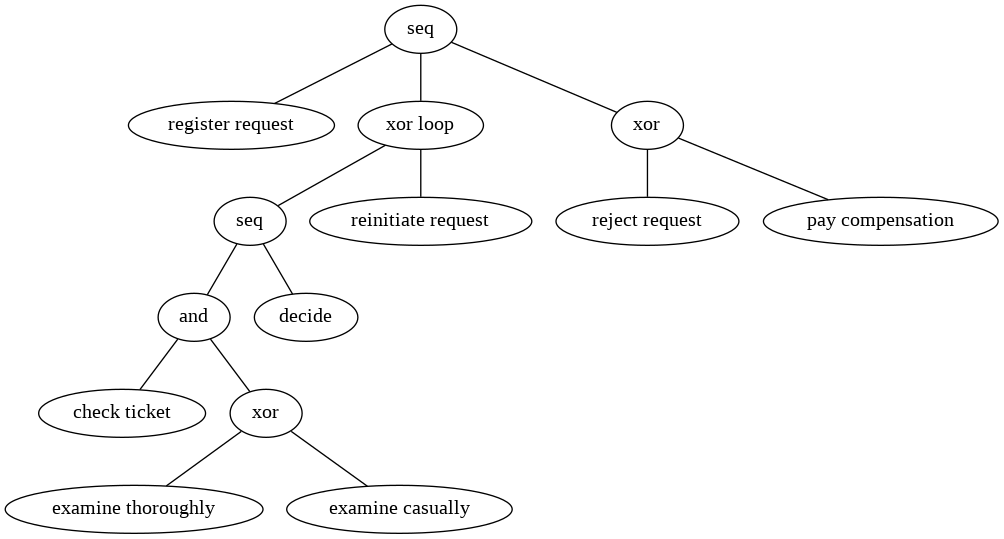

In [31]:
gviz = pt_visualizer.apply(tree_i)
pt_visualizer.view(gviz)

### **Heuristics Miner**

Algorytm Heuristic Miner jest stworzony na bazie algorytmu Alpha jednak bierze pod uwagę częstotliwość, wykrywa krótkie pętle oraz rozpoznaje omijanie aktywności. Wciąż jednak nie
gwarantuje poprawnego modelu procesu. Wynikiem działania tego algortmu jest Sieć Heurystyczna, czyli obiekt, który zawiera czynności i relacje między nimi. Sieć heurystyczną może następnie przekształcić w sieć Petriego.

In [32]:
heu_net = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})


Przedstawienie modelu w postaci sieci heurystycznej:

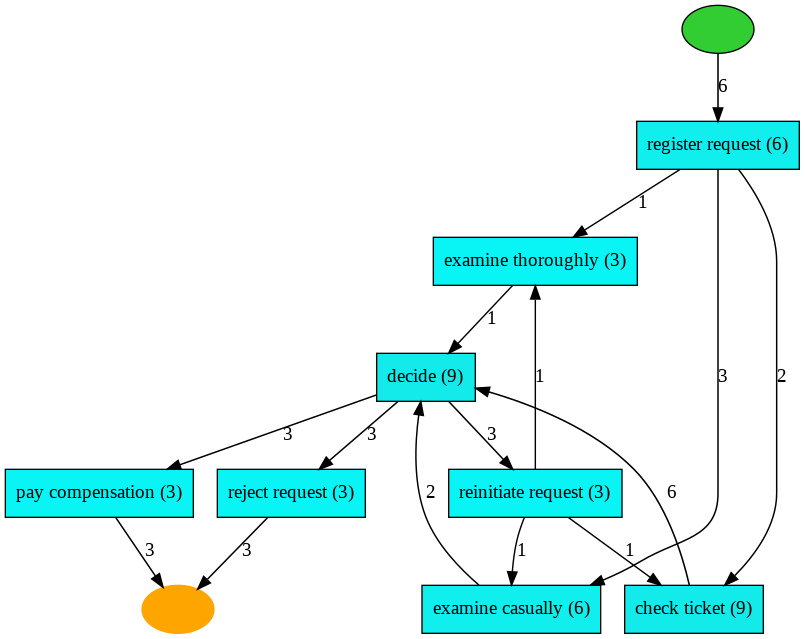

In [33]:
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

Sieć Heurystyczna przypomina stworzony wcześniej graf bezpośrednich podążeń

Na podstawie algorytmu Heuristics Miner możemy otrzymać Sieć Petriego.

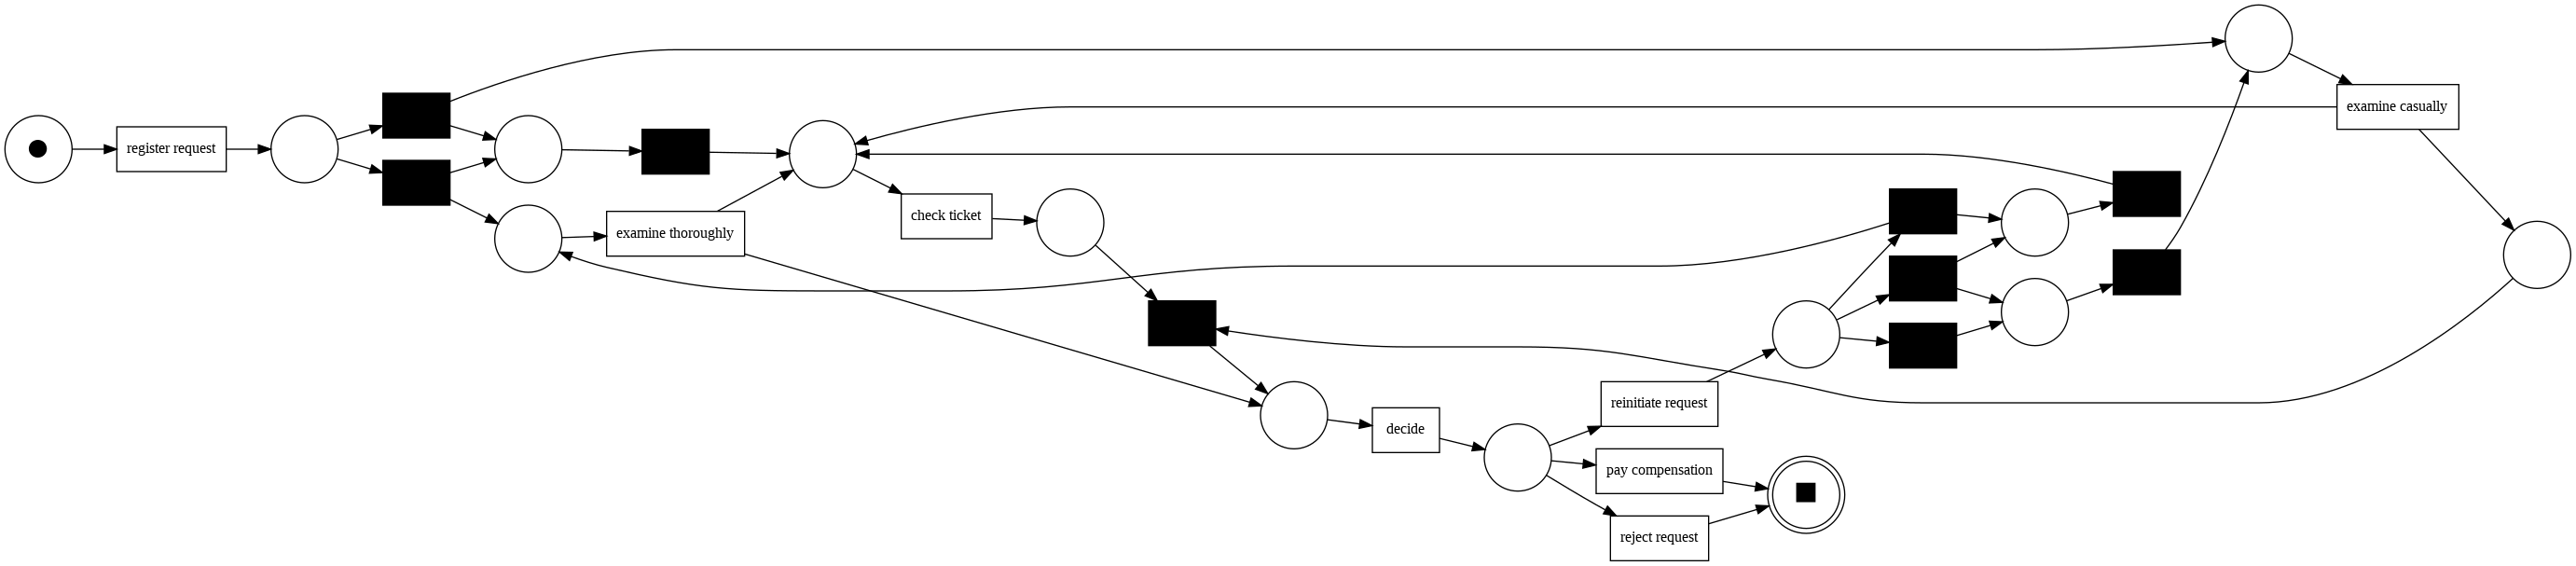

In [34]:
net_h, initial_marking_h, final_marking_h = heuristics_miner.apply(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})

gviz = pm4py.visualization.petri_net.visualizer.apply(net_h, initial_marking_h, final_marking_h)
petri_visualizer.view(gviz)

Konwersja sieci Petriego, otrzymanej za pomocą algorytmu Heuristics Miner, na drzewo procesów w większości przypadków się nie powiedzie. Sieć Petriego otrzymana powyżej, jest znacznie bardziej skomplikowana od tej otrzymanej za pomocą algorytmu Alpha Miner bądź Inductive Miner. Analizując jej przebieg możemy zauważyć, że nie jest ona poprawna, występują w niej między innymi martwe przejścia.

In [35]:
try:
  tree_h = wf_net_converter.apply(net_h, initial_marking_h, final_marking_h)
  gviz = pt_visualizer.apply(tree_h, 
                           parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
  pt_visualizer.view(gviz)
except ValueError: 
  print("Parsing of WF-net Failed")

Parsing of WF-net Failed


## **Przykład II**

### **Alpha Miner**

In [40]:
net1_a, initial_marking1_a, final_marking1_a = alpha_miner.apply(log1)

Wizualizacja w postaci sieci Petriego:

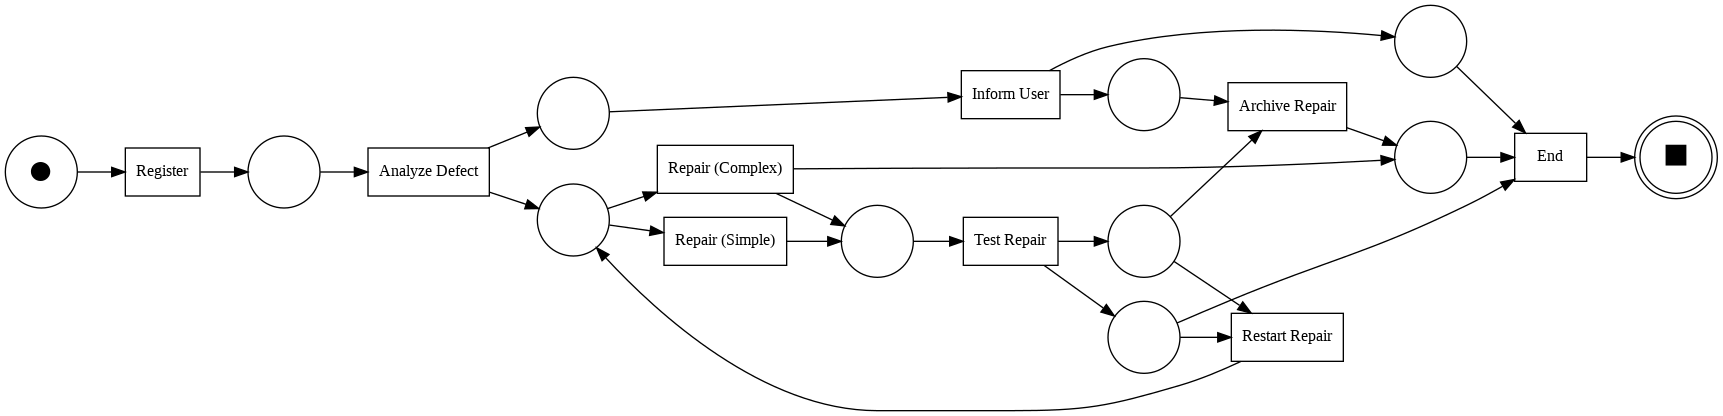

In [42]:
gviz = pm4py.visualization.petri_net.visualizer.apply(net1_a, initial_marking1_a, final_marking1_a)
petri_visualizer.view(gviz)

Konwersja do postaci drzewa procesu:

In [43]:
try:
  tree1_a = wf_net_converter.apply(net1_a, initial_marking1_a, final_marking1_a)
  gviz = pt_visualizer.apply(tree1_a, 
                           parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
  pt_visualizer.view(gviz)
except ValueError: 
  print("Parsing of WF-net Failed")

Parsing of WF-net Failed


Sieć Petriego otrzymana na podstawie tego dziennika zdarzeń, w przypadku użycia algorytmu Alpha Miner nie daje sprowadzić się do drzewa procesów. Otrzymana Sieć Petriego nie jest poprawna.

### **Inductive Miner**

In [44]:
net1_i, initial_marking1_i, final_marking1_i = inductive_miner.apply(log1)
tree1_i = inductive_miner.apply_tree(log1)

Wizualizacja w postaci drzewa procesów:

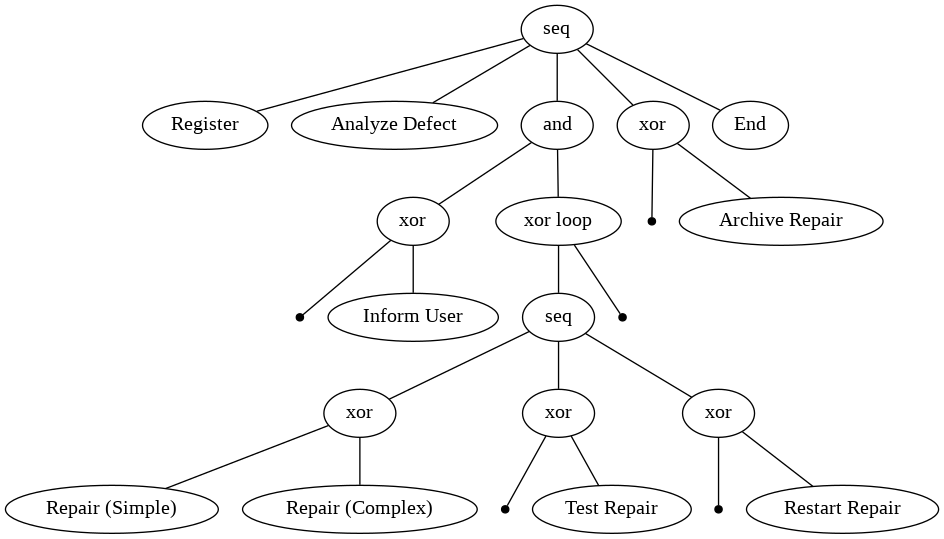

In [45]:
gviz = pt_visualizer.apply(tree1_i)
pt_visualizer.view(gviz)


Wizualizacja w postaci sieci Petriego:

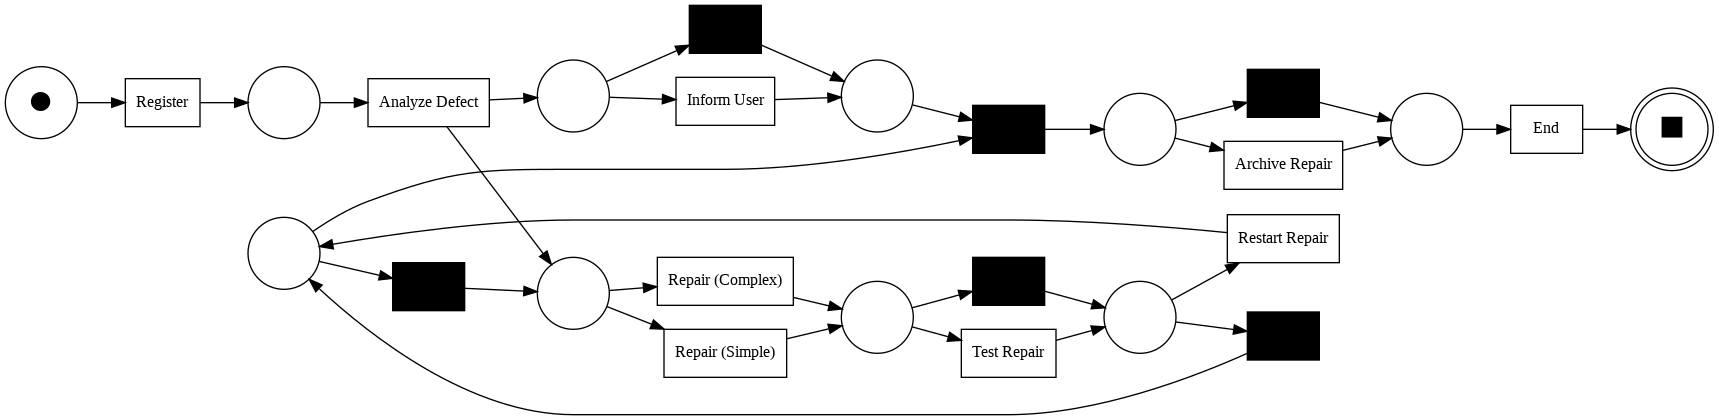

In [46]:
gviz = pm4py.visualization.petri_net.visualizer.apply(net1_i, initial_marking1_i, final_marking1_i)
petri_visualizer.view(gviz)

### **Heuristics Miner**

In [47]:
heu_net_1 = heuristics_miner.apply_heu(log1, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})

Wizualizacja w postaci sieci heurystycznej:

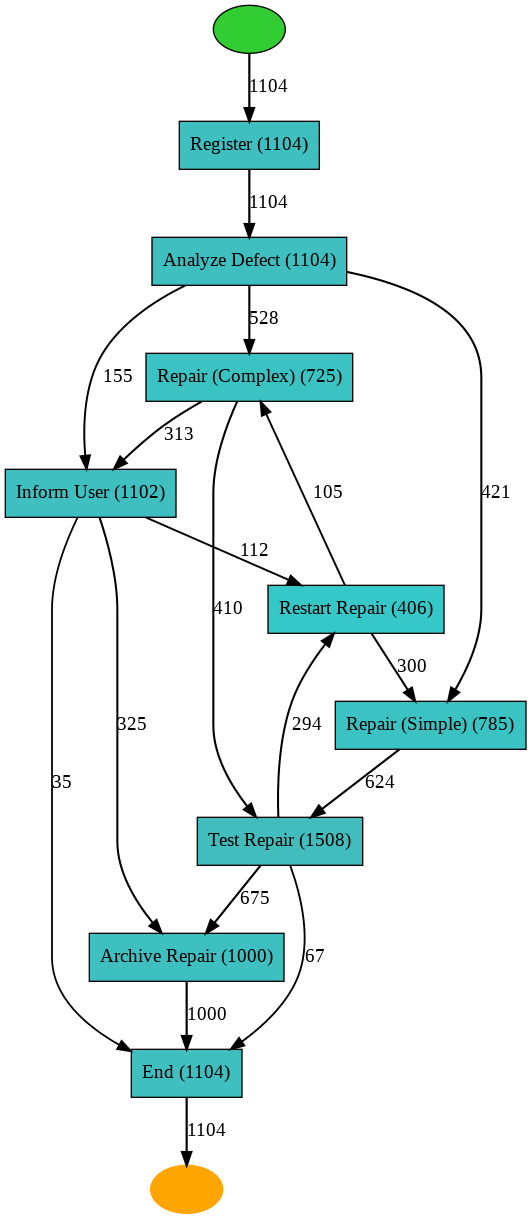

In [48]:
gviz = hn_visualizer.apply(heu_net_1)
hn_visualizer.view(gviz)

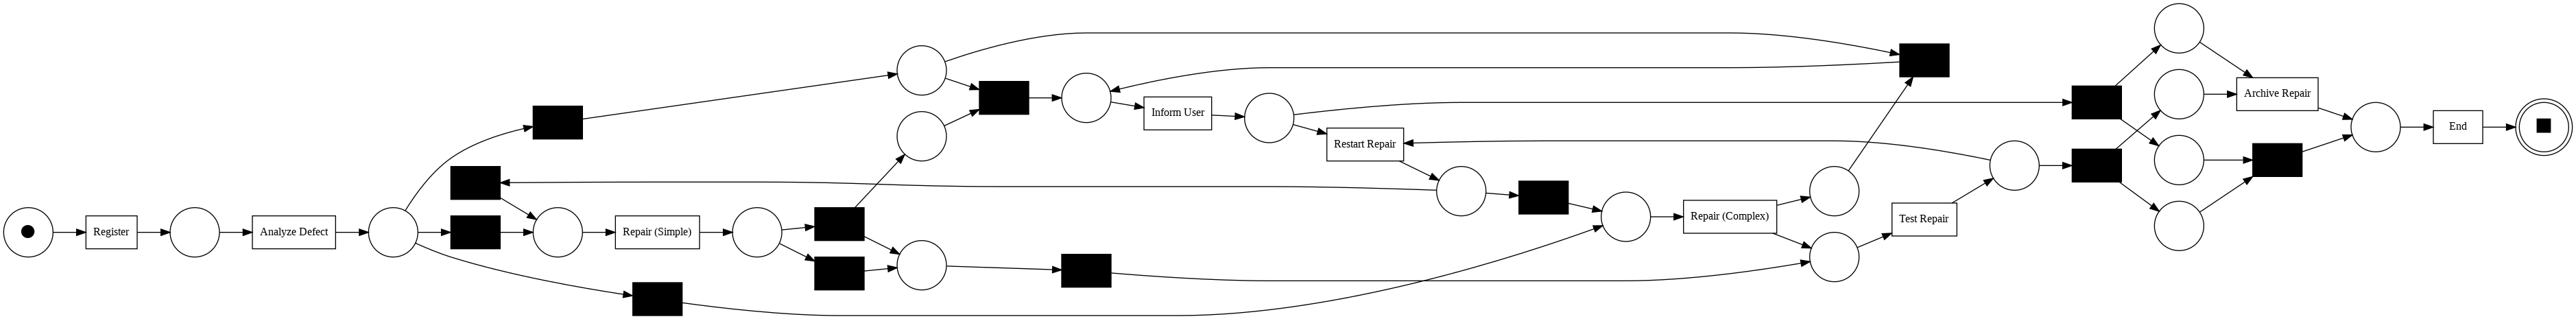

In [49]:
net1_h, initial_marking1_h, final_marking1_h = heuristics_miner.apply(log1, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})

gviz = pm4py.visualization.petri_net.visualizer.apply(net1_h, initial_marking1_h, final_marking1_h)
petri_visualizer.view(gviz)

Konwersja sieci Petriego na drzewo procesów, podobnie jak w przykładzie I, nie powiodła się. Spodziewanym rezultatem konwersji sieci Petriego do postaci drzewa, jest otrzymanie błędu. Podana powyżej sieć nie ma możliwości ukończenia.

In [50]:
try:  
  tree1_h = wf_net_converter.apply(net1_h, initial_marking1_h, final_marking1_h)
  gviz = pt_visualizer.apply(tree1_h, 
                           parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
  pt_visualizer.view(gviz)

except ValueError: 
  print("Parsing of WF-net Failed")

Parsing of WF-net Failed


## **Przykład III**

### **Alpha Miner**

In [51]:
net2_a, initial_marking2_a, final_marking2_a = alpha_miner.apply(log2)

Wizualizacja w postaci sieci Petriego

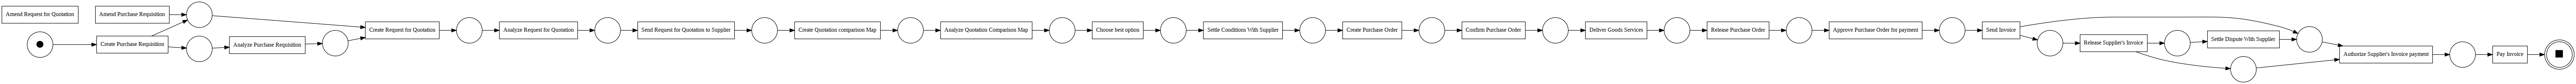

In [53]:
gviz = pm4py.visualization.petri_net.visualizer.apply(net2_a, initial_marking2_a, final_marking2_a)
petri_visualizer.view(gviz)

Możemy zauważyć, że aktywność *Amend Request for Quotation* została "oderwana", a więc nie ma połączenia zarówno  początkiem jak i końcem sieci. Podana wyżej sieć nie jest więc siecią WF.

Ponieważ wygenerowana za pomocą algorytmu Alpha Miner sieć Petriego nie jest siecią WF, nie możliwe jest jest sprowadzenia do postaci drzewa.

In [56]:
try:
  tree2_a = wf_net_converter.apply(net2_a, initial_marking2_a, final_marking2_a)
  gviz = pt_visualizer.apply(tree2_a, 
                           parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
  pt_visualizer.view(gviz)
except ValueError: 
  print("The Petri net provided is not a WF-net")

The Petri net provided is not a WF-net


### **Inductive Miner**

In [57]:
net2_i, initial_marking2_i, final_marking2_i= inductive_miner.apply(log2)
tree2_i = inductive_miner.apply_tree(log2)

Wizualizacja w postaci sieci Petriego:

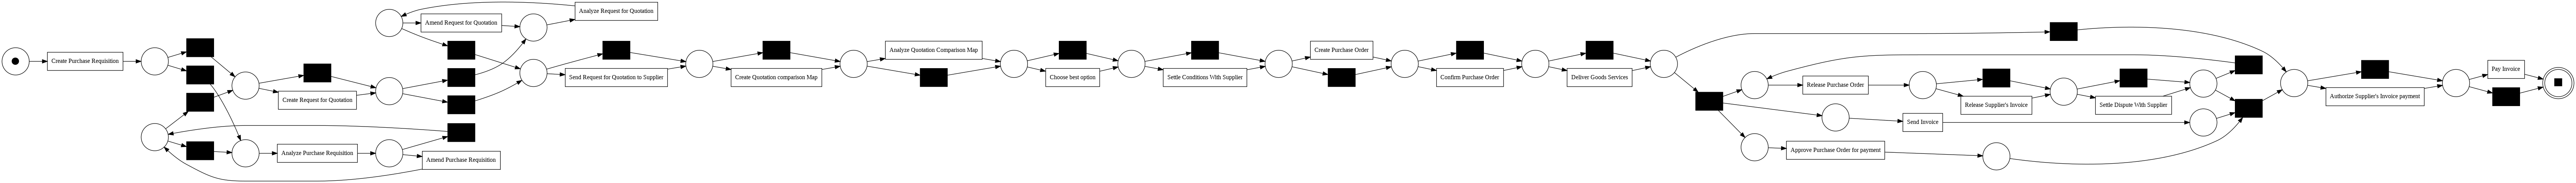

In [58]:
gviz = pm4py.visualization.petri_net.visualizer.apply(net2_i, initial_marking2_i, final_marking2_i)
petri_visualizer.view(gviz)

Wizualizacja w postaci drzewa procesów:

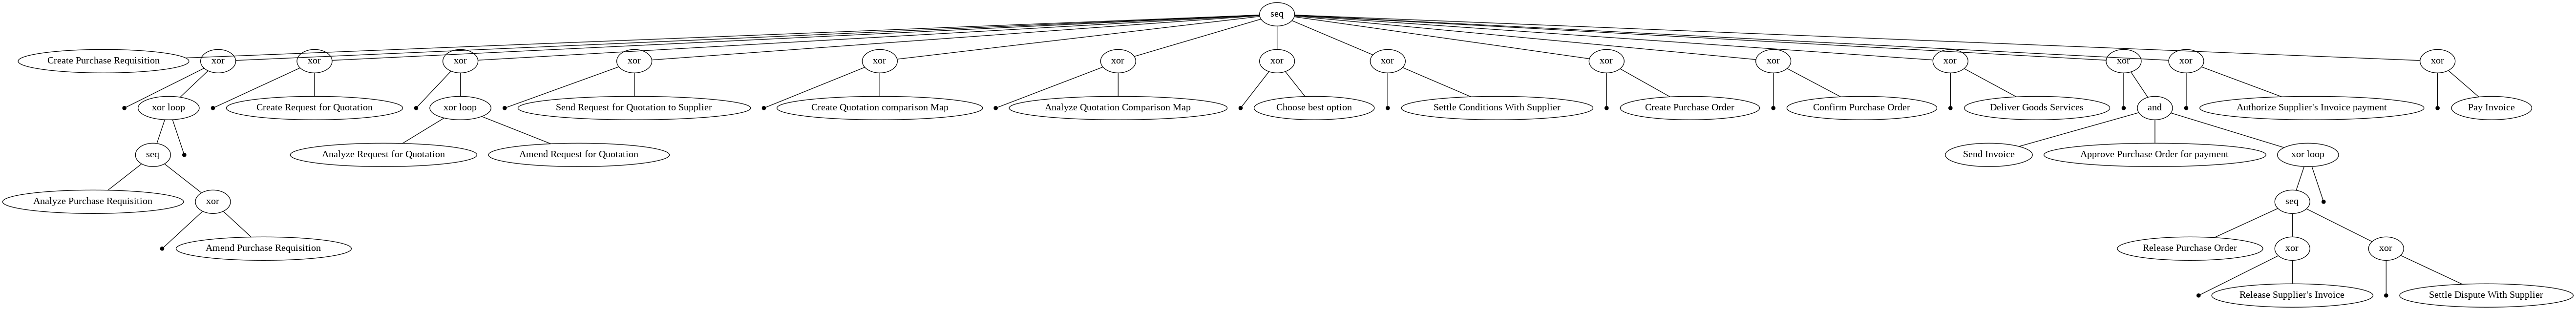

In [59]:
gviz = pt_visualizer.apply(tree2_i)
pt_visualizer.view(gviz)


### **Heuristics Miner**

In [60]:
heu_net_2 = heuristics_miner.apply_heu(log2, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})


Wizualizacja w postaci sieci heurystycznej:

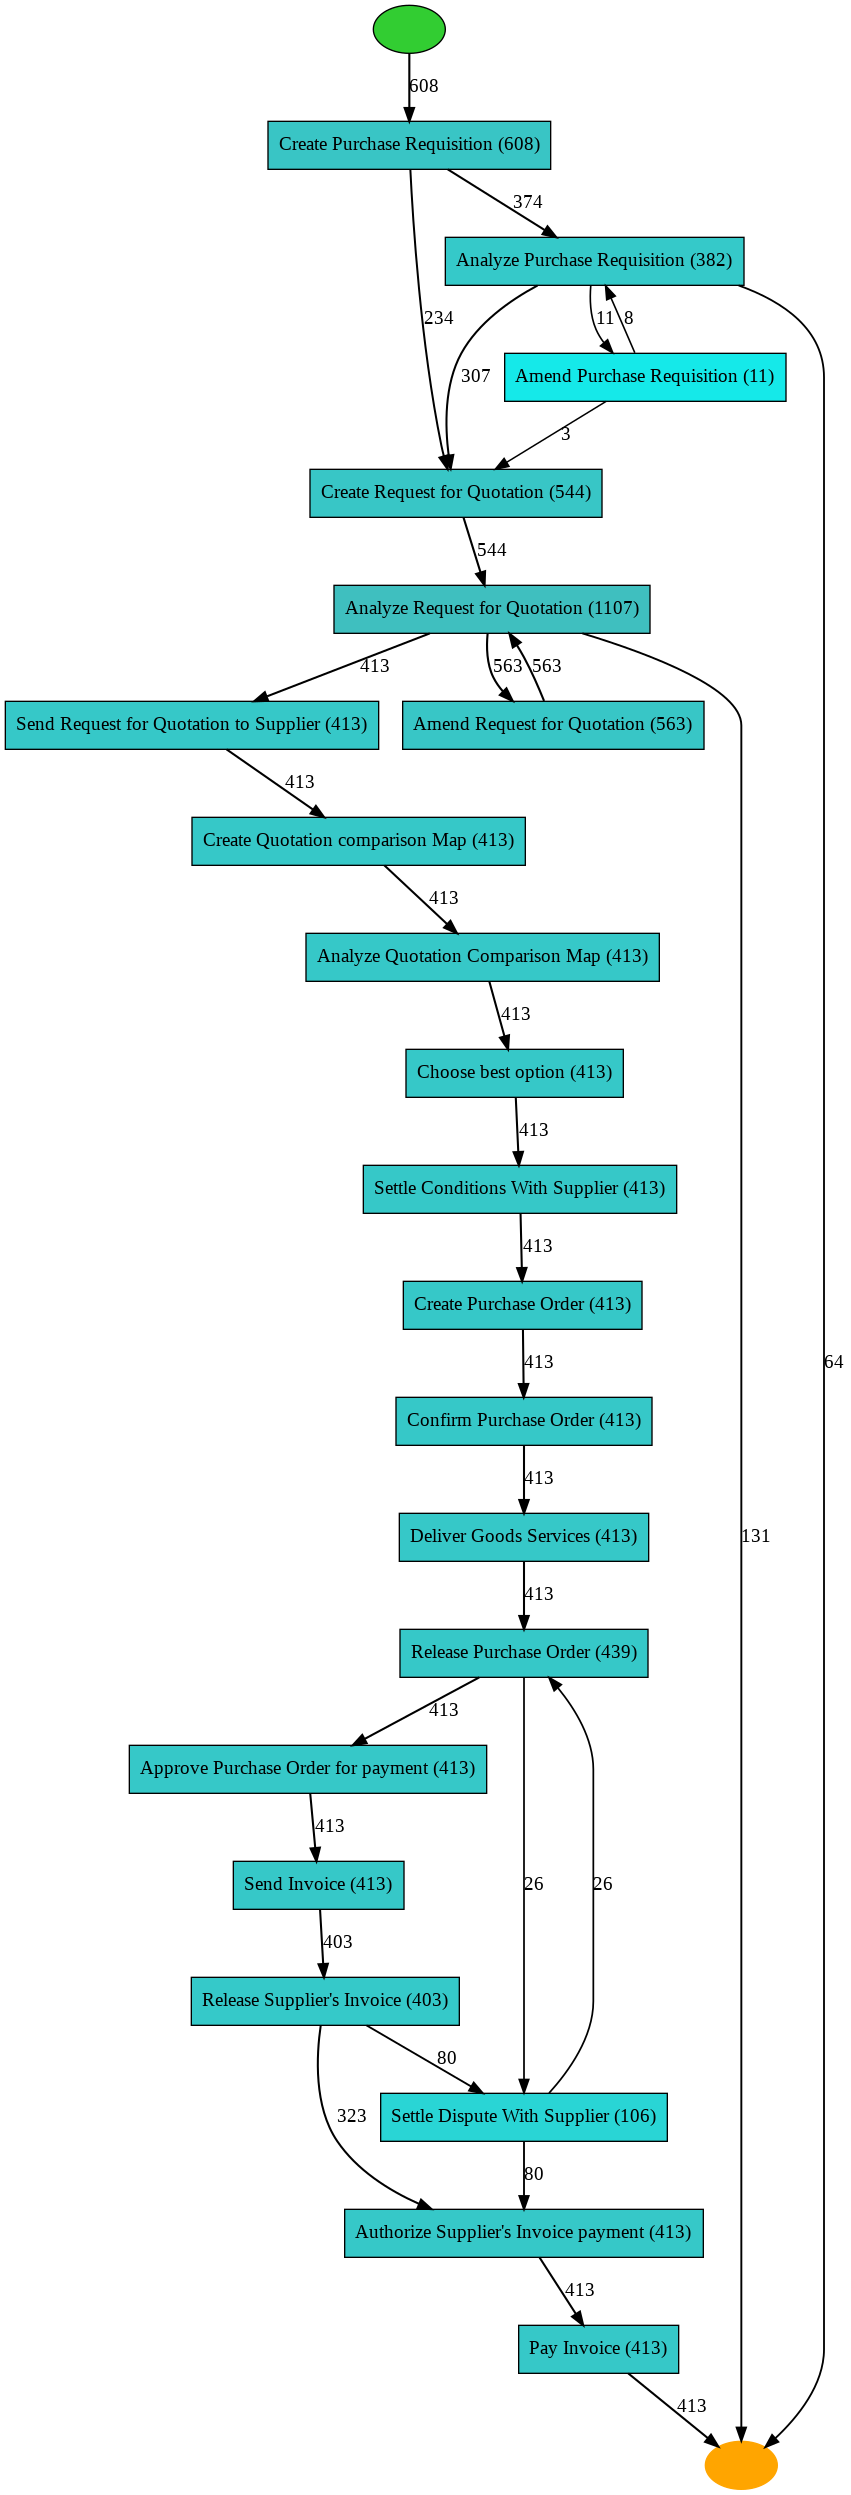

In [61]:
gviz = hn_visualizer.apply(heu_net_2)
hn_visualizer.view(gviz)

Wizualizacja w postaci sieci Petriego:

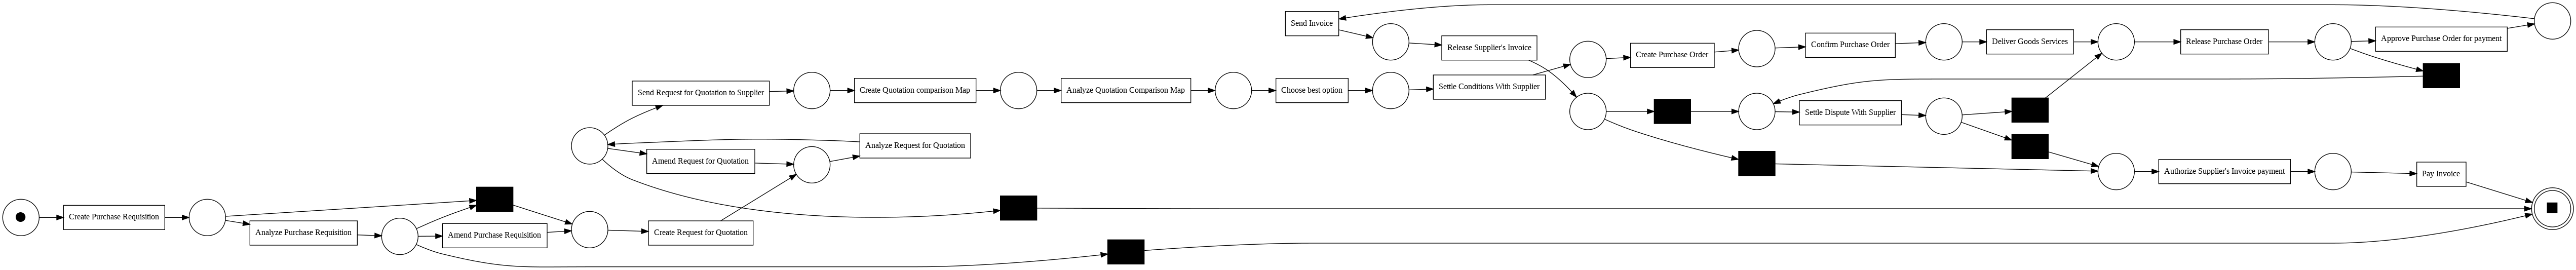

In [62]:
net2_h, initial_marking2_h, final_marking2_h = heuristics_miner.apply(log2, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.1})

gviz = pm4py.visualization.petri_net.visualizer.apply(net2_h, initial_marking2_h, final_marking2_h)
petri_visualizer.view(gviz)

Konwersja sieci Petriego na drzewo procesów:

In [63]:
try:
  tree = wf_net_converter.apply(net2_h, initial_marking2_h, final_marking2_h)
  gviz = pt_visualizer.apply(tree, 
                           parameters={pt_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"})
  pt_visualizer.view(gviz)

except ValueError: 
  print("Parsing of WF-net Failed")

Parsing of WF-net Failed


Również w tym przykładzie konwersja sieci Petriego, otrzymanej za pomocą algorytmu Heuristics Miner, na drzewo procesów nie jest możliwa.